### this script is to extract events using odds ratio, do calibration based on the templates and finally plot the figures that will be needed in the paper

In [18]:
import pandas as pd
df_m = pd.read_csv("data/ee-fm/df_m.csv")
df_f = pd.read_csv("data/ee-fm/df_f.csv")

In [19]:
import itertools
import spacy
import ast 

# nlp = spacy.load('en') # JULIE edits: remove nlp and replace nlp with sp
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

def chain(array):
    array = ast.literal_eval(array)
    return list(itertools.chain.from_iterable(array))

def events_only(array):
    events = []
    if(len(array) > 0):
        for event in array:
            trigger_word = event["triggers"][0]["text"]
            w = sp(trigger_word)
            if w[0].lemma_ not in all_stopwords:
                events.append(w[0].lemma_)
    return events

In [20]:
df_f

,Unnamed: 0,Unnamed: 0.1,name,name_url,gender,person_info,personal_life,career,occupation,pl_events,pl_ev_lemma,career_events,career_ev_lemma
0,0,0,Jody Adams (chef),https://en.wikipedia.org/wiki/Jody_Adams_(chef),F,"[{'section': 'Career', 'info': ['In 2011, Adam...",[],"[[{'event_type': 'Business:Start-Org', 'trigge...",chefs,[],[],"[{'event_type': 'Business:Start-Org', 'trigger...","['open', 'open', 'provide', 'illustrate']"
1,1,1,Einat Admony,https://en.wikipedia.org/wiki/Einat_Admony,F,"[{'section': 'Early life', 'info': ['Admony is...",[],"[[{'event_type': 'Business:Start-Org', 'trigge...",chefs,[],[],"[{'event_type': 'Business:Start-Org', 'trigger...","['open', 'introduce', 'list', 'appear', 'retur..."
2,2,2,Karen Akunowicz,https://en.wikipedia.org/wiki/Karen_Akunowicz,F,"[{'section': 'References', 'info': []}]",[],[],chefs,[],[],[],[]
3,3,3,Devin Alexander,https://en.wikipedia.org/wiki/Devin_Alexander,F,"[{'section': 'Biography', 'info': ['In 2006, s...",[],[],chefs,[],[],[],[]
4,4,4,Fatima Ali,https://en.wikipedia.org/wiki/Fatima_Ali,F,"[{'section': 'Early life', 'info': [""Fatima Al...",[],"[[{'event_type': '', 'triggers': [{'event_type...",chefs,[],[],"[{'event_type': '', 'triggers': [{'event_type'...","['continue', 'begin', 'win', 'vote', 'finish']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5271,5271,925,Diana Wynyard,/wiki/Diana_Wynyard,F,"[{'section': 'Life and career', 'info': ['Born...","[[{'event_type': 'Life:Marry', 'triggers': [{'...",[],acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'die', 'rehearse', 'replace', 'dea...",[],[]
5272,5272,926,Susannah York,/wiki/Susannah_York,F,"[{'section': 'Early life', 'info': [""York was ...","[[{'event_type': 'Life:Marry', 'triggers': [{'...","[[{'event_type': '', 'triggers': [{'event_type...",acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'divorce', 'bear', 'play', 'evoke'...","[{'event_type': '', 'triggers': [{'event_type'...","['play', 'begin', 'perform', 'agree', 'appear'..."
5273,5273,929,Loretta Young,/wiki/Loretta_Young,F,"[{'section': 'Early life', 'info': ['She was b...","[[{'event_type': 'Life:Marry', 'triggers': [{'...","[[], [{'event_type': 'Life:Marry', 'triggers':...",acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'marriage', 'marriage', 'married',...","[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'marriage', 'marry', 'annul', 'elo..."
5274,5274,931,Renée Zellweger,/wiki/Ren%C3%A9e_Zellweger,F,"[{'section': 'Early life', 'info': ['Renée Kat...","[[{'event_type': 'Life:Marry', 'triggers': [{'...","[[{'event_type': 'Life:Die', 'triggers': [{'ev...",acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'engage', 'obtain', 'meet', 'separ...","[{'event_type': 'Life:Die', 'triggers': [{'eve...","['kill', 'receive', 'note', 'applaud', 'play',..."


In [23]:
def extract_events(df_nomi_female):
    # JULIE edits: comment out the first four lines because they are already calculated in the provided dfs
    # no need to redo 
    # saves computation power/cost 
#     df_nomi_female["pl_events"] = df_nomi_female["personal_life"].apply(ast.literal_eval)
#     df_nomi_female["pl_ev_lemma"] = df_nomi_female["pl_events"].apply(ast.literal_eval)
#     df_nomi_female["career_events"] = df_nomi_female["career"].apply(chain)
#     df_nomi_female["career_ev_lemma"] = df_nomi_female["career_events"].apply(events_only)
    df_nomi_female["career_ev_lemma"] = df_nomi_female["career_ev_lemma"].apply(ast.literal_eval)
    df_nomi_female["pl_ev_lemma"] = df_nomi_female["pl_ev_lemma"].apply(ast.literal_eval)
    df_nomi_female["pl_ev_num"] = df_nomi_female["pl_ev_lemma"].apply(len)
    df_nomi_female["cr_ev_num"] = df_nomi_female["career_ev_lemma"].apply(len)
    return df_nomi_female

## odds ratio calculation function
### *--------------------------------------------------------*

### *--------------------------------------------------------*

In [22]:
from collections import OrderedDict
def odds_ratio(f_dict, m_dict, topk=50, threshold=2):
    very_small_value = 0.00001
    if len(f_dict.keys()) != len(m_dict.keys()):
        raise Exception("The category for analyzing the male and female should be the same!")
    else:
        odds_ratio = {}
        total_num_f = sum(f_dict.values())
        total_num_m = sum(m_dict.values())
        for key in f_dict.keys():
            m_num = m_dict[key]
            f_num = f_dict[key]
            non_f_num = total_num_f - f_num
            non_m_num = total_num_m - m_num
            if f_num >= threshold and m_num >= threshold:
                # we only consider the events where there are at least {thresohld} occurences for both gender
                odds_ratio[key] = round((m_num / f_num) / (non_m_num / non_f_num), 2)
            else:
                continue
        return OrderedDict(sorted(odds_ratio.items(), key=itemgetter(1), reverse=True)[:topk]), \
            OrderedDict(sorted(odds_ratio.items(), key=itemgetter(1))[:topk])

In [24]:
import pickle
import itertools
import spacy
from operator import itemgetter
from collections import Counter
import logging
from datetime import datetime
import numpy as np

In [25]:
df_m = extract_events(df_m)
df_f = extract_events(df_f)

In [26]:
def calculate_dict(female_array, male_array):
    counter_f_h = Counter(female_array)
    counter_m_h = Counter(male_array)
    
    # make sure there is no key lookup error
    for key in set(counter_f_h) - set(counter_m_h):
        counter_m_h[key] = 0
    for key in set(counter_m_h) - set(counter_f_h):
        counter_f_h[key] = 0

    return counter_f_h, counter_m_h

In [27]:
def counter_odds_career(career_evs_female, career_evs_male):
    counter_f_c, counter_m_c = calculate_dict(career_evs_female, career_evs_male)
    odds_m_c, odds_f_c = odds_ratio(counter_f_c, counter_m_c)
    return counter_f_c, counter_m_c, odds_m_c, odds_f_c

def check_keyword(array):
    return keyword in array

In [28]:
# there are two ways to do the chain list function: one is applicable to career
# the other is applicable to the personal life section, please choose the one based on the data
# def chain_list(array):
#     array_new = []
#     for i in array:
#         array_new.append(ast.literal_eval(i))
#     return (list(itertools.chain.from_iterable(array_new)))

# JULIE edits: commenting out this second definition of the function
# because the first one works with the data format, not the second
# this is also extremely poor programming practice

def chain_list(array):
    return list(itertools.chain.from_iterable(array))

In [29]:
new_occupations = ["writers", "acting", "comedians", "podcasters", "dancers", "artists", "chefs", "musicians"]
result_counter = {}
result_odds = {}
for new_occupation in new_occupations:
    print("occupation: ", new_occupation)
    df_m_occ, df_f_occ = df_m[df_m["occupation"] == new_occupation], df_f[df_f["occupation"] == new_occupation]
    # to make sure there are equal size of celebrities 
    thres = min(len(df_m_occ), len(df_f_occ))
    df_m_occ, df_f_occ = df_m_occ[:thres], df_f_occ[:thres]
#     pl_evs_f, pl_evs_m = chain(df_female_ev["pl_ev_lemma"]), chain(df_male_ev["pl_ev_lemma"])
    cr_evs_f = chain_list(df_f_occ["career_ev_lemma"].to_list())
    cr_evs_m = chain_list(df_m_occ["career_ev_lemma"].to_list())
    counter_f_c, counter_m_c, odds_m_c, odds_f_c = counter_odds_career(cr_evs_f, cr_evs_m)
    result_counter[new_occupation] = {
        "female": counter_f_c,
        "male": counter_m_c
    }
    result_odds[new_occupation] = {
        "female": odds_f_c,
        "male": odds_m_c
    }

occupation:  writers
occupation:  acting
occupation:  comedians
occupation:  podcasters
occupation:  dancers
occupation:  artists
occupation:  chefs
occupation:  musicians


In [30]:
for occupation in new_occupations:
    print("occupation: ", occupation)
    # before calibration
    # "female top 10"
    print("*"*10 + "female top 10" + "*"*10)
    print(list(result_odds[occupation]["female"].keys())[:10])
    # "male top 10"
    print("*"*10 + "male top 10" + "*"*10)
    print(list(result_odds[occupation]["male"].keys())[:10])


occupation:  writers
**********female top 10**********
['divorce', 'marriage', 'involve', 'organize', 'wedding', 'donate', 'fill', 'pass', 'participate', 'document']
**********male top 10**********
['argue', 'election', 'protest', 'rise', 'shoot', 'host', 'kill', 'close', 'purchase', 'land']
occupation:  acting
**********female top 10**********
['relocate', 'adopt', 'place', 'wedding', 'divorce', 'guest', 'rank', 'resume', 'trip', 'notice']
**********male top 10**********
['support', 'battle', 'mean', 'parole', 'assassination', 'convict', 'arrest', 'able', 'settle', 'occur']
occupation:  comedians
**********female top 10**********
['birth', 'eliminate', 'wedding', 'relocate', 'partner', 'impersonate', 'decline', 'pursue', 'audition', 'discover']
**********male top 10**********
['enjoy', 'cause', 'hear', 'buy', 'conceive', 'fail', 'injury', 'allow', 'enter', 'acquire']
occupation:  podcasters
**********female top 10**********
['land', 'interview', 'portray', 'married', 'report', 'praise

## calibration step1: get <em>template sentences</em>

In [31]:
final = pd.read_csv("data/final_manual.csv")
templates = pd.DataFrame(final).drop_duplicates(subset=['Name', "Gender", "Occupation"])

In [32]:
templates.head(10)

,Event,Name,Gender,Occupation,Keyword,Text
0,"{'text': 'hired', 'lemma': 'hire', 'start_toke...",Dolester Miles,F,chefs,hire,"In 1982, Frank Stitt opened Highlands Bar and ..."
1,"{'text': 'hired', 'lemma': 'hire', 'start_toke...",Nancy Silverton,F,chefs,hire,After Silverton returned to Los Angeles in 198...
2,"{'text': 'hired', 'lemma': 'hire', 'start_toke...",Beau MacMillan,M,chefs,hire,MacMillan moved to Los Angeles to become sous ...
3,"{'text': 'hired', 'lemma': 'hire', 'start_toke...",Anthony Amoroso,M,chefs,hire,"In 2003, Amoroso relocated to Las Vegas, Nevad..."
4,"{'text': 'met', 'lemma': 'meet', 'start_token'...",Debra Ponzek,F,chefs,meet,Ponzek married fellow chef Bobby Flay in May 1...
5,"{'text': 'met', 'lemma': 'meet', 'start_token'...",Ashleigh Shanti,F,chefs,meet,"In October 2018, Shanti met John Fleer, owner-..."
6,"{'text': 'met', 'lemma': 'meet', 'start_token'...",Ettore Boiardi,M,chefs,meet,"In 1927, Boiardi met Maurice and Eva Weiner wh..."
7,"{'text': 'sold', 'lemma': 'sell', 'start_token...",Ida Bailey Allen,F,chefs,sell,In 1924 Allen was food editor of the Sunday Ne...
9,"{'text': 'selling', 'lemma': 'sell', 'start_to...",Iliana Regan,F,chefs,sell,"In 2008, Regan began selling microgreens and v..."
10,"{'text': 'sold', 'lemma': 'sell', 'start_token...",Peter Grunauer,M,chefs,sell,"In 1979, Peter was joined by Karl Zartler, who..."


In [33]:
# not reporting some of the occupations because of the small data size
selected_occupation = ["dancers", "comedians", "podcasters", "writers", "artists", "musicians", "chefs"]
select_templates = templates[templates["Occupation"].isin(selected_occupation)]

## calibration step 2: based on the <em>template sentences</em>, swap names and get new sentences for calibration

In [34]:
import re 
import json

def swap_female(current_name, current_gender, text, future_name, future_gender):
    current_name = re.sub("[\(\[].*?[\)\]]", "", current_name)
    first_name = current_name.split(" ")[-1]  
    re_dict = {
        first_name: future_name,
    }
    if current_gender == "F" and future_gender == "M":
        re_dict["she"] = "he"
        re_dict["her"] = "his"
        re_dict["She"] = "He"
        re_dict["Her"] = "His"
    elif current_gender == "M" and future_gender == "F":
        re_dict["he"] = "she"
        re_dict["his"] = "her"
        re_dict["him"] = "her"
        re_dict["He"] = "She"
        re_dict["His"] = "Her"
        
#     print(re_dict) # JULIE edits: disable printing -- takes too long
 
    new_tokens = []
    for token in sp(text):
        if token.text in re_dict.keys():
            new_tokens.append(re_dict[token.text])
        else:
            new_tokens.append(token.text)
    replaced_string = " ".join(ele for ele in new_tokens)
    return replaced_string

In [35]:
# for single events, do event detection
# JULIE edits: modify path name
name_list = json.loads(open("data/names.json", "rb").readlines()[0])

# fifty sample names
sample_name = 50
male_names = name_list["men"][:50]
female_names = name_list["women"][:50]

In [36]:
gen_sen = []
for i, row in select_templates.iterrows():
    original_text = row["Text"]
    cur_gender = row["Gender"]
    cur_name = row["Name"]
    f_gens = ["M", "F"]
    for f_gen in f_gens:
        if f_gen == "M":
            for name in male_names:
                future_text =  swap_female(cur_name, cur_gender, original_text, name, f_gen)
                gen_sen.append({
                    "Event":row["Event"],
                    "Name": name,
                    "Gender": f_gen,
                    "Occupation": row["Occupation"],
                    "Keyword": row["Keyword"],
                    "Text": future_text
                })
        if f_gen == "F":
            for name in female_names:
                future_text =  swap_female(cur_name, cur_gender, original_text, name, f_gen)
                gen_sen.append({
                    "Event":row["Event"],
                    "Name": name,
                    "Gender": f_gen,
                    "Occupation": row["Occupation"],
                    "Keyword": row["Keyword"],
                    "Text": future_text
                })

In [37]:
import pickle
import pandas as pd

# read the result
result_list = []
for occupation in new_occupations:
    # to get this, you will need to run the event extraction model from Han et. al 2019.
    # JULIE edits: change path
    df = pickle.load(open(f"data/ee-model/res_{occupation}.p", "rb"))
    result = {}
    for key, group in df.groupby(["Gender", "Keyword"]):
        if group["Result"].unique().tolist() == [False]:
            # for the case where target events in all templates all did not get detected
            # then do not calibrate this event and directly use the original occurence
            print(f"not calibrating event {key[1]} for gender {key[0]}?")
            print("Example: ", group["Text"].tolist()[0])
        event = key[1]
        gender = key[0]
        if event not in result:
            print(f"adding event {event}")
            result[event] = {}
        percent = sum(group["Result"].tolist()) / len(group["Result"].tolist())
        result[event][gender] = percent
    result_list.append(result)

adding event appear
adding event attend
adding event begin
adding event birth
adding event bury
adding event charge
adding event claim
adding event come
adding event describe
adding event die
adding event grow
adding event know
adding event publish
adding event raise
adding event report
adding event return
adding event serve
adding event state
adding event suffer
not calibrating event war for gender F?
Example:  Lucy Jennifer was the daughter of Colonel William Houston and Cornelia Humes Graham Jennifer . Her grandfather was Major General Robert Jennifer , who served in the War of 1812 , the Mexican – American War , and the Civil War.[4 ] 

adding event war
not calibrating event war for gender M?
Example:  Lucy Michael was the daughter of Colonel William Houston and Cornelia Humes Graham Michael . His grandfather was Major General Robert Michael , who served in the War of 1812 , the Mexican – American War , and the Civil War.[4 ] 

adding event accuse
adding event arrest
adding event a

## calculate the odds ratio again after getting the calibration result

In [38]:
cali_result = {}
for i in range(0, len(new_occupations)):
    curr_occu = new_occupations[i]
    if curr_occu not in cali_result:
        cali_result[curr_occu] = {
            "F": {},
            "M": {}
        }
    cali_dict = result_list[i]
    prev_counter_f = result_counter[new_occupations[i]]["female"]
    for f_key in prev_counter_f.keys():
        if f_key in cali_dict:
            if "F" in cali_dict[f_key]:
                percent = cali_dict[f_key]["F"]
                if percent != 0:
                    new_count = prev_counter_f[f_key] / percent
                else:
                    new_count = prev_counter_f[f_key] 
                cali_result[curr_occu]["F"][f_key] = new_count
            else:
                cali_result[curr_occu]["F"][f_key] = prev_counter_f[f_key]
        else:
            cali_result[curr_occu]["F"][f_key] = prev_counter_f[f_key]
                
    prev_counter_m = result_counter[new_occupations[i]]["male"]
    for m_key in prev_counter_m.keys():
        if m_key in cali_dict:
            if "M" in cali_dict[m_key]:
                percent = cali_dict[m_key]["M"]
                if percent != 0:
                    new_count = prev_counter_m[m_key] / percent
                else:
                    new_count = prev_counter_m[m_key] 
                cali_result[curr_occu]["M"][m_key] = new_count
            else:
                cali_result[curr_occu]["M"][m_key] = prev_counter_m[m_key]  
        else:
            cali_result[curr_occu]["M"][m_key] = prev_counter_m[m_key]

## get the final result that is reported in the paper
### also plot the bartchart of the calibration result

Occupation:  writers
male:  ['argue', 'election', 'protest', 'rise', 'shoot', 'host', 'kill', 'close', 'purchase', 'land']
female:  ['divorce', 'marriage', 'involve', 'birth', 'organize', 'wedding', 'donate', 'fill', 'pass', 'participate']
Occupation:  acting
male:  ['battle', 'support', 'mean', 'parole', 'assassination', 'convict', 'arrest', 'able', 'settle', 'occur']
female:  ['relocate', 'pregnant', 'adopt', 'place', 'wedding', 'divorce', 'guest', 'rank', 'resume', 'trip']
Occupation:  comedians
male:  ['enjoy', 'visit', 'cause', 'hear', 'buy', 'conceive', 'fail', 'injury', 'allow', 'enter']
female:  ['birth', 'eliminate', 'wedding', 'relocate', 'partner', 'impersonate', 'decline', 'pursue', 'audition', 'discover']
Occupation:  podcasters
male:  ['come', 'direct', 'ask', 'tell', 'continue', 'provide', 'bring', 'election', 'sell', 'meet']
female:  ['land', 'interview', 'portray', 'married', 'report', 'praise', 'talk', 'shoot', 'earn', 'premier']
Occupation:  dancers
male:  ['team', '

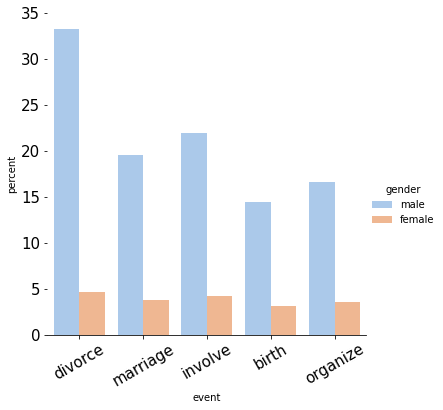

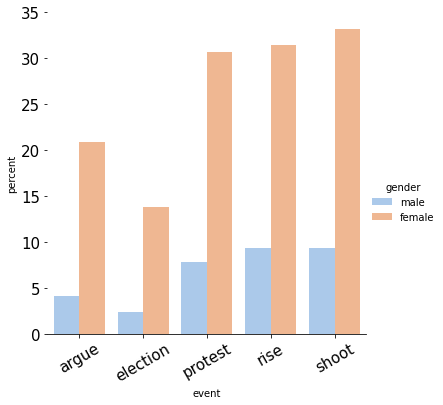

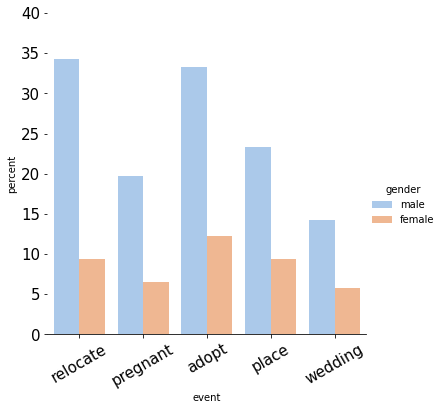

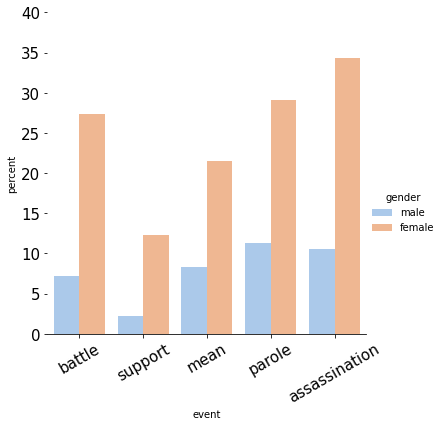

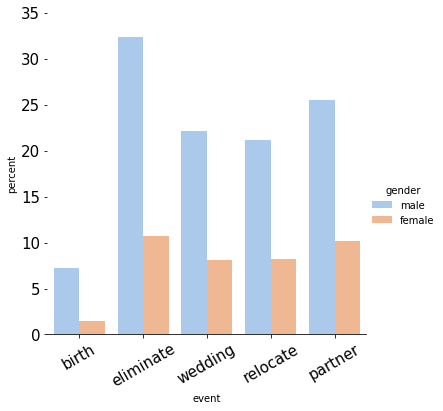

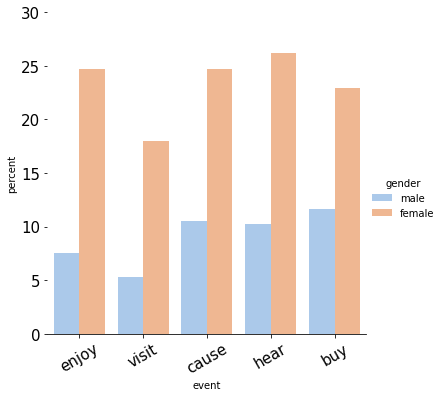

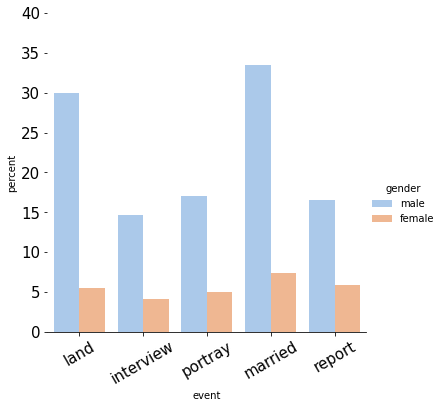

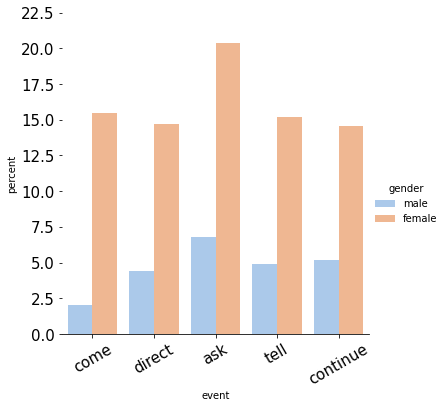

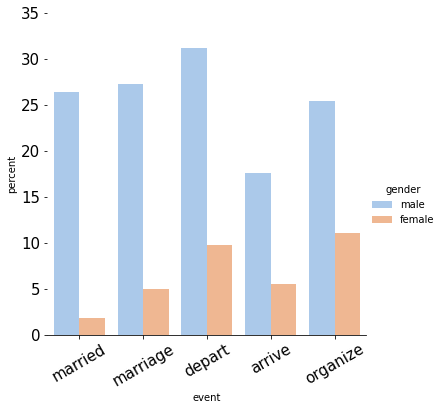

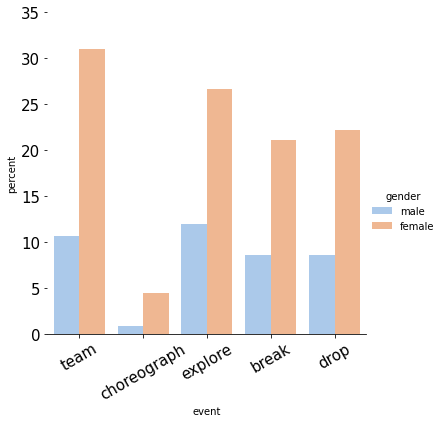

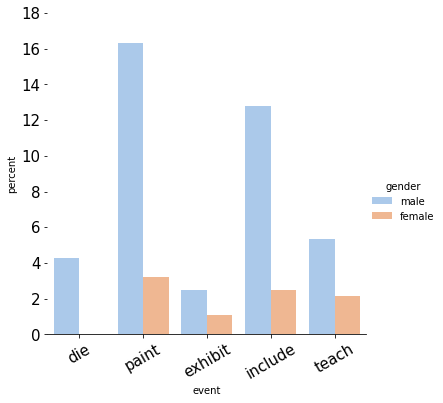

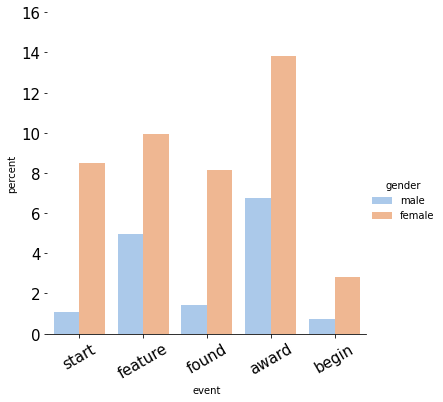

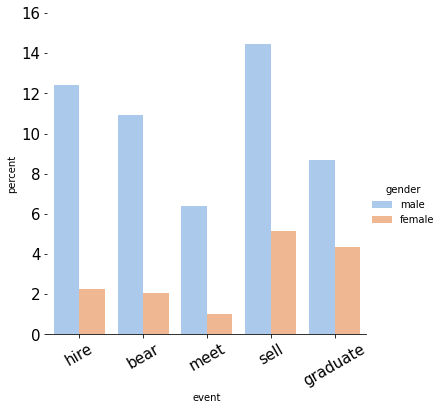

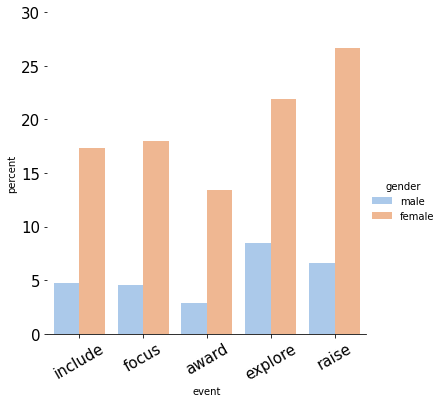

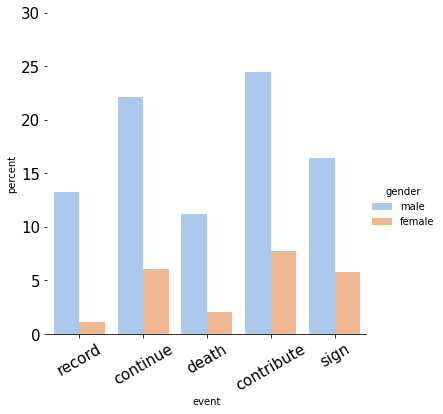

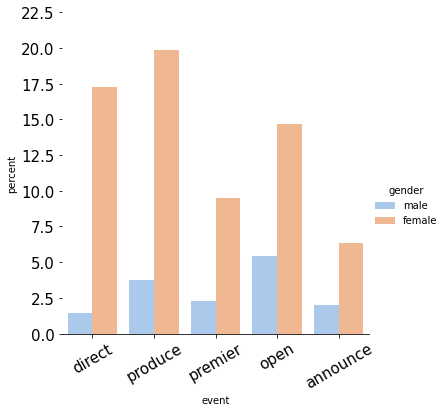

In [40]:
import seaborn as sns
import operator
import matplotlib.pyplot as plt
for occu in new_occupations:
    print("Occupation: ", occu)
    m_dict_occu, f_dict_occu = odds_ratio(cali_result[occu]["F"], cali_result[occu]["M"])
    print("male: ", list(m_dict_occu.keys())[:10])
    print("female: ", list(f_dict_occu.keys())[:10])
    female_events = list(f_dict_occu.keys())[:5]
    male_events = list(m_dict_occu.keys())[:5]
    
    sorted_counter_f_pl = {k: v for k, v in sorted(cali_result[occu]["F"].items(), key=lambda item: item[1], reverse=True)}
    sorted_counter_m_pl = {k: v for k, v in sorted(cali_result[occu]["M"].items(), key=lambda item: item[1], reverse=True)}
    m_topic_pl = list(sorted_counter_m_pl.keys())
    f_topic_pl = list(sorted_counter_f_pl.keys())
    for gender in ["F", "M"]:
        position = []
        if gender == "F":
            select_events = female_events
        else:
            select_events = male_events
        
        for m_topic in select_events:
            position.append({
                "percent": m_topic_pl.index(m_topic) / len(m_topic_pl) * 100,
                "gender": "male",
                "event": m_topic
                })
            position.append({
                "percent": f_topic_pl.index(m_topic) / len(m_topic_pl) * 100,
                "gender": "female",
                "event": m_topic
                })

        df = pd.DataFrame(position)
        g = sns.catplot(x='event', y='percent', hue='gender', data=df, kind='bar', palette = sns.color_palette("pastel"))
        g.set_xticklabels(fontsize = 15, rotation=30)
        g.set_yticklabels(fontsize = 15)
        g.despine(left=True)    
        # JULIE edits: don't need to save, just display
        
#         g.savefig(f"pl_figs/{occu}_{gender}.pdf", dpi=1000)
plt.show()

In [41]:
events = '''Occupation:  writers
male:  ['argue', 'election', 'protest', 'rise', 'shoot', 'host', 'kill', 'close', 'purchase', 'land']
female:  ['divorce', 'marriage', 'involve', 'birth', 'organize', 'wedding', 'donate', 'fill', 'pass', 'participate']
Occupation:  acting
male:  ['battle', 'support', 'mean', 'parole', 'assassination', 'convict', 'arrest', 'able', 'settle', 'occur']
female:  ['relocate', 'pregnant', 'adopt', 'place', 'wedding', 'divorce', 'guest', 'rank', 'resume', 'trip']
Occupation:  comedians
male:  ['enjoy', 'visit', 'cause', 'hear', 'buy', 'conceive', 'fail', 'injury', 'allow', 'enter']
female:  ['birth', 'eliminate', 'wedding', 'relocate', 'partner', 'impersonate', 'decline', 'pursue', 'audition', 'discover']
Occupation:  podcasters
male:  ['come', 'direct', 'ask', 'tell', 'continue', 'provide', 'bring', 'election', 'sell', 'meet']
female:  ['land', 'interview', 'portray', 'married', 'report', 'praise', 'talk', 'shoot', 'earn', 'premier']
Occupation:  dancers
male:  ['team', 'choreograph', 'explore', 'break', 'drop', 'think', 'add', 'celebrate', 'injury', 'suffer']
female:  ['married', 'marriage', 'depart', 'arrive', 'organize', 'try', 'consist', 'promote', 'train', 'divorce']
Occupation:  artists
male:  ['start', 'feature', 'found', 'award', 'begin', 'appear', 'join', 'influence', 'work', 'create']
female:  ['die', 'paint', 'exhibit', 'include', 'teach', 'publish', 'explore', 'use', 'draw', 'produce']
Occupation:  chefs
male:  ['include', 'focus', 'award', 'explore', 'raise', 'close', 'gain', 'spend', 'launch', 'find']
female:  ['hire', 'bear', 'meet', 'sell', 'graduate', 'debut', 'travel', 'eliminate', 'sign', 'describe']
Occupation:  musicians
male:  ['direct', 'produce', 'premier', 'open', 'announce', 'follow', 'begin', 'star', 'write', 'act']
female:  ['record', 'continue', 'death', 'contribute', 'sign', 'appear', 'perform', 'teach', 'accord', 'found']'''

In [42]:
import ast
occu_gender_events = {}
for line in events.split('\n'):
    if line.startswith('Occupation'):
        occu = line[len('Occupation:  '):]
    if line.startswith('male'):
        evs = ast.literal_eval(line[len('male:  '):])
        occu_gender_events[(occu, 'male')] = evs
    elif line.startswith('female'):
        evs = ast.literal_eval(line[len('female:  '):])
        occu_gender_events[(occu, 'female')] = evs
occu_gender_events

{('writers', 'male'): ['argue',
  'election',
  'protest',
  'rise',
  'shoot',
  'host',
  'kill',
  'close',
  'purchase',
  'land'],
 ('writers', 'female'): ['divorce',
  'marriage',
  'involve',
  'birth',
  'organize',
  'wedding',
  'donate',
  'fill',
  'pass',
  'participate'],
 ('acting', 'male'): ['battle',
  'support',
  'mean',
  'parole',
  'assassination',
  'convict',
  'arrest',
  'able',
  'settle',
  'occur'],
 ('acting', 'female'): ['relocate',
  'pregnant',
  'adopt',
  'place',
  'wedding',
  'divorce',
  'guest',
  'rank',
  'resume',
  'trip'],
 ('comedians', 'male'): ['enjoy',
  'visit',
  'cause',
  'hear',
  'buy',
  'conceive',
  'fail',
  'injury',
  'allow',
  'enter'],
 ('comedians', 'female'): ['birth',
  'eliminate',
  'wedding',
  'relocate',
  'partner',
  'impersonate',
  'decline',
  'pursue',
  'audition',
  'discover'],
 ('podcasters', 'male'): ['come',
  'direct',
  'ask',
  'tell',
  'continue',
  'provide',
  'bring',
  'election',
  'sell',
  '

In [54]:
new_occupations = ["writers", "acting", "comedians", "podcasters", "dancers", "artists", "chefs", "musicians"]
for occu in new_occupations:
    print(occu.capitalize(), '& F & &  ', ', '.join(occu_gender_events[(occu, 'female')][:5]), '\\\\')
    print('       & M & & ', ', '.join(occu_gender_events[(occu, 'male')][:5]), '\\\\')

Writers & F & &   divorce, marriage, involve, birth, organize \\
       & M & &  argue, election, protest, rise, shoot \\
Acting & F & &   relocate, pregnant, adopt, place, wedding \\
       & M & &  battle, support, mean, parole, assassination \\
Comedians & F & &   birth, eliminate, wedding, relocate, partner \\
       & M & &  enjoy, visit, cause, hear, buy \\
Podcasters & F & &   land, interview, portray, married, report \\
       & M & &  come, direct, ask, tell, continue \\
Dancers & F & &   married, marriage, depart, arrive, organize \\
       & M & &  team, choreograph, explore, break, drop \\
Artists & F & &   die, paint, exhibit, include, teach \\
       & M & &  start, feature, found, award, begin \\
Chefs & F & &   hire, bear, meet, sell, graduate \\
       & M & &  include, focus, award, explore, raise \\
Musicians & F & &   record, continue, death, contribute, sign \\
       & M & &  direct, produce, premier, open, announce \\


In [ ]:
writers female birth/wedding
acting female relocate/de

In [8]:
from WEAT.weat import run_test, load_embedding

In [11]:
glove_embeddings = load_embedding('WEAT/embeddings/glove.840B.300d.processed.txt')
w2v_embeddings = load_embedding('WEAT/embeddings/GoogleNews-vectors-negative300.bin')

WEAT/embeddings/glove.840B.300d.processed.txt
WEAT/embeddings/GoogleNews-vectors-negative300.bin


In [15]:
new_occupations = ["writers", "acting", "comedians", "podcasters", "dancers", "artists", "chefs", "musicians"]
config = {}
config['A'] = ["male", "man", "boy", "brother", "he", "him", "his", "son", "father", "uncle", "grandfather"]
config['B'] = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter", "mother", "aunt", "grandmother"]

for occu in new_occupations:
    config['X'] = occu_gender_events[(occu, 'male')]
    config['Y'] = occu_gender_events[(occu, 'female')]
    glove_weat = run_test(config, glove_embeddings)
    w2v_weat = run_test(config, w2v_embeddings)
    print(f'{occu} glove {glove_weat[0]:.2f} w2v {w2v_weat[0]:.2f}')
    

writers glove 0.92 w2v 0.68
acting glove 1.06 w2v 0.87
comedians glove 0.49 w2v 0.36
podcasters glove 0.10 w2v -0.28
dancers glove 0.47 w2v 0.53
artists glove 0.20 w2v 0.64
chefs glove -0.53 w2v -0.41
musicians glove -0.24 w2v 0.19


In [16]:
new_occupations = ["writers", "acting", "comedians", "podcasters", "dancers", "artists", "chefs", "musicians"]
config = {}
config['A'] = ["male", "man", "boy", "brother", "he", "him", "his", "son", "father", "uncle", "grandfather"]
config['B'] = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter", "mother", "aunt", "grandmother"]

for occu in new_occupations:
    config['X'] = occu_gender_events[(occu, 'male')][:5]
    config['Y'] = occu_gender_events[(occu, 'female')][:5]
    glove_weat = run_test(config, glove_embeddings)
    w2v_weat = run_test(config, w2v_embeddings)
    print(f'{occu} glove {glove_weat[0]:.2f} w2v {w2v_weat[0]:.2f}')
    

writers glove 1.36 w2v 1.31
acting glove 1.46 w2v 1.47
comedians glove 0.30 w2v 0.59
podcasters glove 0.51 w2v 0.75
dancers glove 0.43 w2v 0.38
artists glove 0.03 w2v 0.47
chefs glove -0.76 w2v -0.24
musicians glove -0.38 w2v -0.34
